In [173]:
import pandas as pd
import numpy as np

from itertools import combinations
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM

In [174]:
df = pd.read_csv('./data.csv', index_col=0)
deaths_df = df.drop(['new_confirmed_cases'], axis=1).iloc[35:]
deaths_df.head()

,no2,pm25,ozone,new_deaths
Date,,,,
2020-03-01,0.007,11.1,0.045,0.0
2020-03-02,0.022,8.4,0.043,0.0
2020-03-03,0.029,9.4,0.038,0.0
2020-03-04,0.021,15.8,0.029,0.0
2020-03-05,0.029,22.1,0.033,0.0


In [175]:
feature_combinations = {}
features = [col for col in deaths_df.columns if col != 'new_deaths']
for i in range(1,len(features) + 1):
    feature_combinations[i] = list(combinations(features, i))
feature_combinations

{1: [('no2',), ('pm25',), ('ozone',)],
 2: [('no2', 'pm25'), ('no2', 'ozone'), ('pm25', 'ozone')],
 3: [('no2', 'pm25', 'ozone')]}

In [176]:
length_dfs = {}
for length, feature_combination in feature_combinations.items():
    dfs = []
    for feature in feature_combination:
        dfs.append(deaths_df[list(feature) + ['new_deaths']])
    length_dfs[length] = dfs

In [177]:
training_results = {}
days_in = 7
days_out = 5
n_train = int(len(deaths_df)*.8)

features = []
models = []
histories = []
y_and_yhats = []
error_days_out_dicts = []
    
for length, dfs in length_dfs.items():
    
    for df in dfs:
        # Rescale data and reframe to work with LSTM 
        reframed, scaler = scale_vals(df, days_in, days_out)
        cols_to_keep = list(range(1, days_out * (length+1), (length+1)))
        cols_to_drop = [-i for i in range(1,days_out * (length + 1) +1) if i not in cols_to_keep]
        reframed.drop(reframed.columns[cols_to_drop], axis=1, inplace=True)
        reframed_vals = reframed.values
        
        # Split into training and testing datasets, and reshape to work with LSTM
        train = reframed_vals[:n_train]
        test = reframed_vals[n_train:]
        X_train, y_train = train[:,:-days_out],train[:,-days_out:]
        X_test, y_test = test[:,:-days_out],test[:,-days_out:]
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        
        # Build and train the model
        print(f'\n======= Training {list(df.columns)[:length]} =======\n')
        model = build_model(X_train, days_out)
        stop_noimprovement = EarlyStopping(monitor='val_loss', verbose=1, patience=30, min_delta=.00001)
        history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,verbose=1,callbacks=[stop_noimprovement],shuffle=False)
        
        # Derive predictions
        predictions = model.predict(X_test)
        y_and_yhat = {}
        
        for day in range(1, days_out+1):
            y_and_yhat[day] = []
            
        for (prediction, actual) in zip(predictions, y_test):
            for i, day_ahead in enumerate(prediction):
                predicted = np.concatenate(([0]*length, [day_ahead])).reshape(1,-1)
                predict = scaler.inverse_transform(predicted)[0][-1]

                actual_r = np.concatenate(([0]*length, [actual[i]])).reshape(1,-1)
                a = scaler.inverse_transform(actual_r)[0][-1]
                y_and_yhat[i+1].append((a, predict))

        error_days_out = {}
        for day in range(1, days_out+1):
            actual_vals = [vals[0] for vals in y_and_yhat[day]]
            prediction_vals = [vals[1] for vals in y_and_yhat[day]]
            rmse = np.sqrt(mean_squared_error(actual_vals, prediction_vals))
            nrmse = rmse/(df['new_deaths'].max() - df['new_deaths'].min())
            error_days_out[day] = (rmse, nrmse)

        features.append(list(df.columns[:-1]))
        models.append(model)
        histories.append(history)
        y_and_yhats.append(y_and_yhat)
        error_days_out_dicts.append(error_days_out)


======= Training ['no2'] =======

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_258 (LSTM)              (None, 1, 20)             2800      
_________________________________________________________________
lstm_259 (LSTM)              (None, 1, 60)             19440     
_________________________________________________________________
lstm_260 (LSTM)              (None, 1, 100)            64400     
_________________________________________________________________
lstm_261 (LSTM)              (None, 1, 40)             22560     
_________________________________________________________________
lstm_262 (LSTM)              (None, 1, 20)             4880      
_________________________________________________________________
lstm_263 (LSTM)              (None, 4)                 400       
_________________________________________________________________
dense_43 (Dense)  

224/224 [==============================] - 16s 72ms/sample - loss: 0.2960 - val_loss: 0.3832
Epoch 2/200
224/224 [==============================] - 0s 932us/sample - loss: 0.2912 - val_loss: 0.3746
Epoch 3/200
224/224 [==============================] - 0s 936us/sample - loss: 0.2862 - val_loss: 0.3655
Epoch 4/200
224/224 [==============================] - 0s 937us/sample - loss: 0.2808 - val_loss: 0.3553
Epoch 5/200
224/224 [==============================] - 0s 920us/sample - loss: 0.2748 - val_loss: 0.3433
Epoch 6/200
224/224 [==============================] - 0s 928us/sample - loss: 0.2677 - val_loss: 0.3278
Epoch 7/200
224/224 [==============================] - 0s 927us/sample - loss: 0.2585 - val_loss: 0.3057
Epoch 8/200
224/224 [==============================] - 0s 918us/sample - loss: 0.2457 - val_loss: 0.2729
Epoch 9/200
224/224 [==============================] - 0s 963us/sample - loss: 0.2291 - val_loss: 0.2301
Epoch 10/200
224/224 [==============================] - 0s 935us/sa

224/224 [==============================] - 0s 939us/sample - loss: 0.1209 - val_loss: 0.0650
Epoch 79/200
224/224 [==============================] - 0s 944us/sample - loss: 0.1208 - val_loss: 0.0650
Epoch 80/200
224/224 [==============================] - 0s 946us/sample - loss: 0.1207 - val_loss: 0.0649
Epoch 81/200
224/224 [==============================] - 0s 932us/sample - loss: 0.1206 - val_loss: 0.0649
Epoch 82/200
224/224 [==============================] - 0s 949us/sample - loss: 0.1205 - val_loss: 0.0649
Epoch 83/200
224/224 [==============================] - 0s 945us/sample - loss: 0.1204 - val_loss: 0.0649
Epoch 84/200
224/224 [==============================] - 0s 934us/sample - loss: 0.1204 - val_loss: 0.0649
Epoch 85/200
224/224 [==============================] - 0s 946us/sample - loss: 0.1203 - val_loss: 0.0649
Epoch 86/200
224/224 [==============================] - 0s 946us/sample - loss: 0.1202 - val_loss: 0.0649
Epoch 87/200
224/224 [==============================] - 0s 

224/224 [==============================] - 0s 938us/sample - loss: 0.2453 - val_loss: 0.2743
Epoch 11/200
224/224 [==============================] - 0s 960us/sample - loss: 0.2336 - val_loss: 0.2451
Epoch 12/200
224/224 [==============================] - 0s 986us/sample - loss: 0.2228 - val_loss: 0.2202
Epoch 13/200
224/224 [==============================] - 0s 931us/sample - loss: 0.2153 - val_loss: 0.2034
Epoch 14/200
224/224 [==============================] - 0s 938us/sample - loss: 0.2098 - val_loss: 0.1924
Epoch 15/200
224/224 [==============================] - 0s 963us/sample - loss: 0.2046 - val_loss: 0.1844
Epoch 16/200
224/224 [==============================] - 0s 990us/sample - loss: 0.1994 - val_loss: 0.1774
Epoch 17/200
224/224 [==============================] - 0s 964us/sample - loss: 0.1943 - val_loss: 0.1700
Epoch 18/200
224/224 [==============================] - 0s 974us/sample - loss: 0.1892 - val_loss: 0.1619
Epoch 19/200
224/224 [==============================] - 0s 

224/224 [==============================] - 0s 965us/sample - loss: 0.1194 - val_loss: 0.0759
Epoch 00087: early stopping

======= Training ['no2', 'pm25'] =======

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_276 (LSTM)              (None, 1, 20)             3360      
_________________________________________________________________
lstm_277 (LSTM)              (None, 1, 60)             19440     
_________________________________________________________________
lstm_278 (LSTM)              (None, 1, 100)            64400     
_________________________________________________________________
lstm_279 (LSTM)              (None, 1, 40)             22560     
_________________________________________________________________
lstm_280 (LSTM)              (None, 1, 20)             4880      
_________________________________________________________________
lstm_281 (LSTM)      

224/224 [==============================] - 0s 940us/sample - loss: 0.1212 - val_loss: 0.1026
Epoch 65/200
224/224 [==============================] - 0s 919us/sample - loss: 0.1210 - val_loss: 0.1027
Epoch 00065: early stopping

======= Training ['no2', 'ozone'] =======

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_282 (LSTM)              (None, 1, 20)             3360      
_________________________________________________________________
lstm_283 (LSTM)              (None, 1, 60)             19440     
_________________________________________________________________
lstm_284 (LSTM)              (None, 1, 100)            64400     
_________________________________________________________________
lstm_285 (LSTM)              (None, 1, 40)             22560     
_________________________________________________________________
lstm_286 (LSTM)              (None, 1, 20)    

Epoch 64/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1212 - val_loss: 0.0987
Epoch 65/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1210 - val_loss: 0.0988
Epoch 66/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1207 - val_loss: 0.0990
Epoch 67/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1204 - val_loss: 0.0991
Epoch 68/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1202 - val_loss: 0.0992
Epoch 69/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1199 - val_loss: 0.0994
Epoch 70/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1196 - val_loss: 0.0995
Epoch 71/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1194 - val_loss: 0.0997
Epoch 72/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1192 - val_loss: 0.0998
Epoch 73/200
224/224 [==============================] - 0s 1ms/s

224/224 [==============================] - 0s 964us/sample - loss: 0.1226 - val_loss: 0.0688
Epoch 44/200
224/224 [==============================] - 0s 954us/sample - loss: 0.1223 - val_loss: 0.0685
Epoch 45/200
224/224 [==============================] - 0s 940us/sample - loss: 0.1219 - val_loss: 0.0682
Epoch 46/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1216 - val_loss: 0.0680
Epoch 47/200
224/224 [==============================] - 0s 954us/sample - loss: 0.1213 - val_loss: 0.0678
Epoch 48/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1211 - val_loss: 0.0676
Epoch 49/200
224/224 [==============================] - 0s 962us/sample - loss: 0.1208 - val_loss: 0.0674
Epoch 50/200
224/224 [==============================] - 0s 969us/sample - loss: 0.1205 - val_loss: 0.0673
Epoch 51/200
224/224 [==============================] - 0s 955us/sample - loss: 0.1203 - val_loss: 0.0672
Epoch 52/200
224/224 [==============================] - 0s 1ms/

224/224 [==============================] - 0s 1ms/sample - loss: 0.1719 - val_loss: 0.1395
Epoch 22/200
224/224 [==============================] - 0s 993us/sample - loss: 0.1648 - val_loss: 0.1303
Epoch 23/200
224/224 [==============================] - 0s 961us/sample - loss: 0.1592 - val_loss: 0.1228
Epoch 24/200
224/224 [==============================] - 0s 959us/sample - loss: 0.1549 - val_loss: 0.1165
Epoch 25/200
224/224 [==============================] - 0s 945us/sample - loss: 0.1515 - val_loss: 0.1111
Epoch 26/200
224/224 [==============================] - 0s 943us/sample - loss: 0.1485 - val_loss: 0.1064
Epoch 27/200
224/224 [==============================] - 0s 942us/sample - loss: 0.1458 - val_loss: 0.1024
Epoch 28/200
224/224 [==============================] - 0s 943us/sample - loss: 0.1434 - val_loss: 0.0989
Epoch 29/200
224/224 [==============================] - 0s 942us/sample - loss: 0.1411 - val_loss: 0.0961
Epoch 30/200
224/224 [==============================] - 0s 93

In [178]:
df_cols = {'features': features, 'model':models, 'history':histories, 'y_and_yhat': y_and_yhats}
for day in range(1, days_out+1):
    df_cols[f'{day} day(s) out RMSE'] = [errs[day][0] for errs in error_days_out_dicts]
    df_cols[f'{day} day(s) out nRMSE'] = [errs[day][1] for errs in error_days_out_dicts]
results = pd.DataFrame(df_cols)
results

,features,model,history,y_and_yhat,1 day(s) out RMSE,1 day(s) out nRMSE,2 day(s) out RMSE,2 day(s) out nRMSE,3 day(s) out RMSE,3 day(s) out nRMSE,4 day(s) out RMSE,4 day(s) out nRMSE,5 day(s) out RMSE,5 day(s) out nRMSE
0,[no2],<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"{1: [(12.999998898245423, 11.658201490741744),...",12.148031,0.133495,13.560256,0.149014,15.110172,0.166046,14.536162,0.159738,13.476998,0.148099
1,[pm25],<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"{1: [(12.999998898245423, 14.987458388636469),...",11.206865,0.123152,10.771677,0.118370,11.681029,0.128363,11.967312,0.131509,12.319236,0.135376
2,[ozone],<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"{1: [(12.999998898245423, 19.514282510722403),...",13.834097,0.152023,13.582572,0.149259,11.769840,0.129339,10.806662,0.118755,12.448638,0.136798
3,"[no2, pm25]",<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"{1: [(12.999998898245423, 16.66215246740904), ...",12.576082,0.138199,13.523779,0.148613,15.542269,0.170794,16.110406,0.177037,14.860854,0.163306
4,"[no2, ozone]",<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"{1: [(12.999998898245423, 14.296790478738636),...",12.760260,0.140223,12.961096,0.142430,16.220865,0.178251,16.634269,0.182794,13.483621,0.148172
5,"[pm25, ozone]",<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"{1: [(12.999998898245423, 19.56117047355361), ...",12.562266,0.138047,11.747786,0.129097,11.922195,0.131013,11.244288,0.123564,13.007230,0.142937
6,"[no2, pm25, ozone]",<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"{1: [(12.999998898245423, 8.64961280530361), (...",12.749435,0.140104,13.296643,0.146117,14.338455,0.157565,14.394299,0.158179,13.366663,0.146886


In [179]:
c = [col for col in list(results.columns) if col == 'features' or ('nRMSE' in col)]
nrmse_results = results[c]
nrmse_results.style.highlight_min(color = 'lightgreen', axis = 0).highlight_max(color = 'red', axis = 0)

,features,1 day(s) out nRMSE,2 day(s) out nRMSE,3 day(s) out nRMSE,4 day(s) out nRMSE,5 day(s) out nRMSE
0,['no2'],0.133495,0.149014,0.166046,0.159738,0.148099
1,['pm25'],0.123152,0.118370,0.128363,0.131509,0.135376
2,['ozone'],0.152023,0.149259,0.129339,0.118755,0.136798
3,"['no2', 'pm25']",0.138199,0.148613,0.170794,0.177037,0.163306
4,"['no2', 'ozone']",0.140223,0.142430,0.178251,0.182794,0.148172
5,"['pm25', 'ozone']",0.138047,0.129097,0.131013,0.123564,0.142937
6,"['no2', 'pm25', 'ozone']",0.140104,0.146117,0.157565,0.158179,0.146886


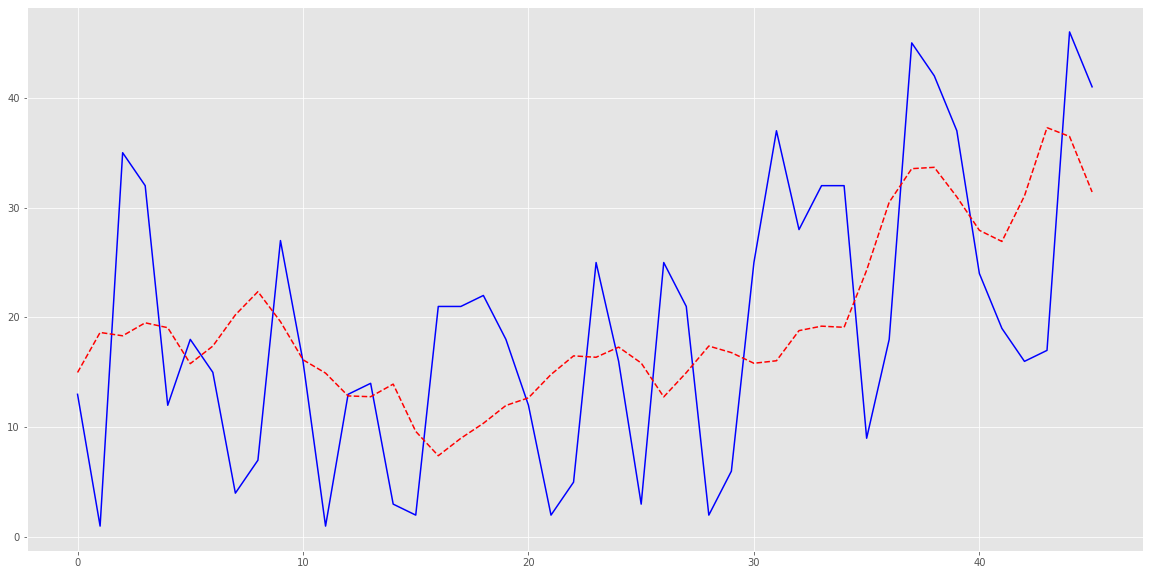

In [180]:
index = 1
days_out_index = 1
acts = [vals[0] for vals in results.iloc[index]['y_and_yhat'][days_out_index]]
preds = [vals[1] for vals in results.iloc[index]['y_and_yhat'][days_out_index]]
plt.plot(acts, color='blue')
plt.plot(preds,'--', color='red')
plt.show()

In [168]:
def scale_vals(data, n_in, n_out):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled,n_in,n_out)
    return reframed, scaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def build_model(X_train, days_out):
    model = Sequential()
    model.add(LSTM(20,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(60,return_sequences=True))
    model.add(LSTM(100,return_sequences=True))
    model.add(LSTM(40,return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(days_out))
    model.compile(loss="mse",optimizer="adam")
    print(model.summary())
    return model